In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import yfinance as yf

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Download ETF data
START_DATE = '2010-04-30'
END_DATE = '2025-04-30'

# Bond, Commodities, Stocks, Volatility
etfs = ['AGG', 'DBC', 'VTI', '^VIX']
data = pd.DataFrame()
data = yf.download(etfs, start=START_DATE, end=END_DATE)['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed


<Axes: xlabel='Date'>

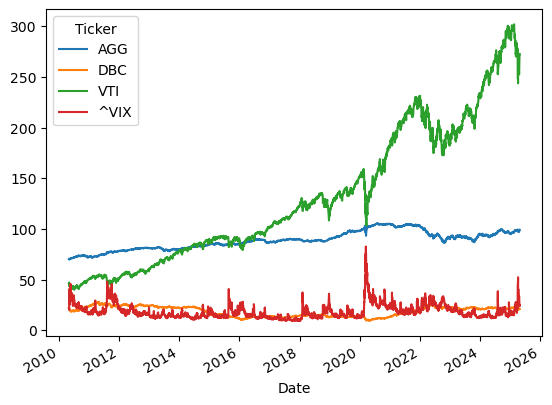

In [4]:
data.plot()

In [5]:
data.isnull().values.any()

False

In [6]:
data.head()

Ticker,AGG,DBC,VTI,^VIX
Date,,,,
2010-04-30,70.167656,21.357914,46.501293,22.049999
2010-05-03,70.034775,21.462780,47.127529,20.190001
2010-05-04,70.316673,20.886009,45.981976,23.840000
2010-05-05,70.262932,20.414108,45.607784,24.910000
2010-05-06,70.363625,20.012121,44.072750,32.799999


In [7]:
def correlation_analysis(df, lookback_window):
    etfs_pairs = list(it.combinations(df.columns, 2))
    correlation = pd.DataFrame()
    for pair in etfs_pairs:
        correlation[str(pair[0])+' <--> '+str(pair[1])] = df[list(pair)].rolling(lookback_window).corr().iloc[0::2,-1].droplevel(1, axis=0)
    return correlation
lookback = 50
rolling_corrs = correlation_analysis(data.pct_change().fillna(0), lookback)[49:] #first 49 values are NaN due to lookback = 50

<Axes: xlabel='Date'>

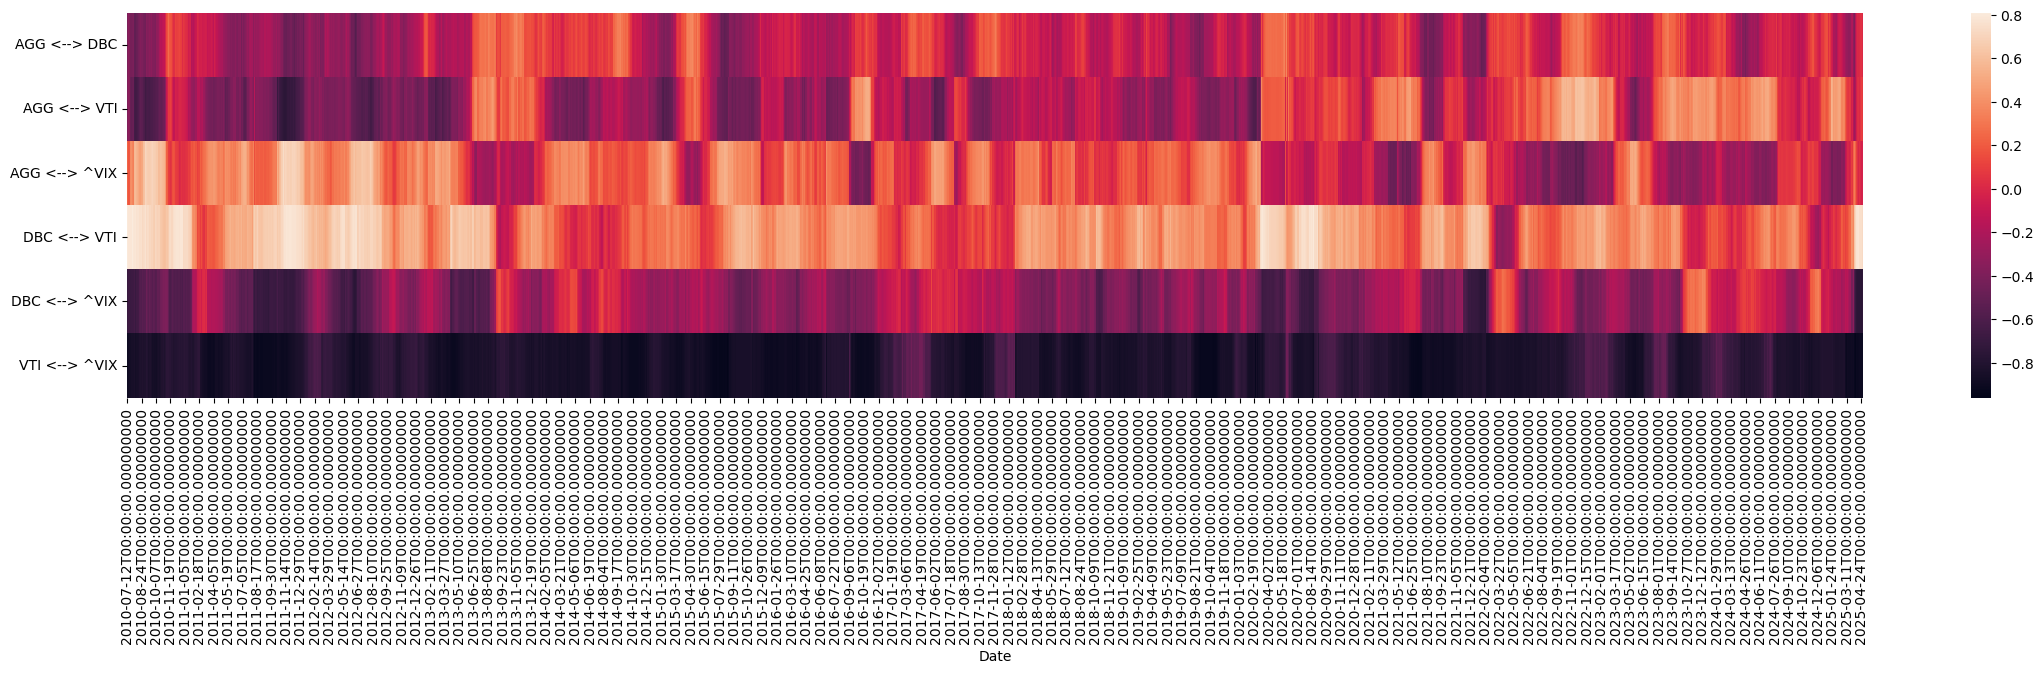

In [8]:
fig, ax = plt.subplots(1,1, figsize=(28,5))
sns.heatmap(rolling_corrs.transpose())

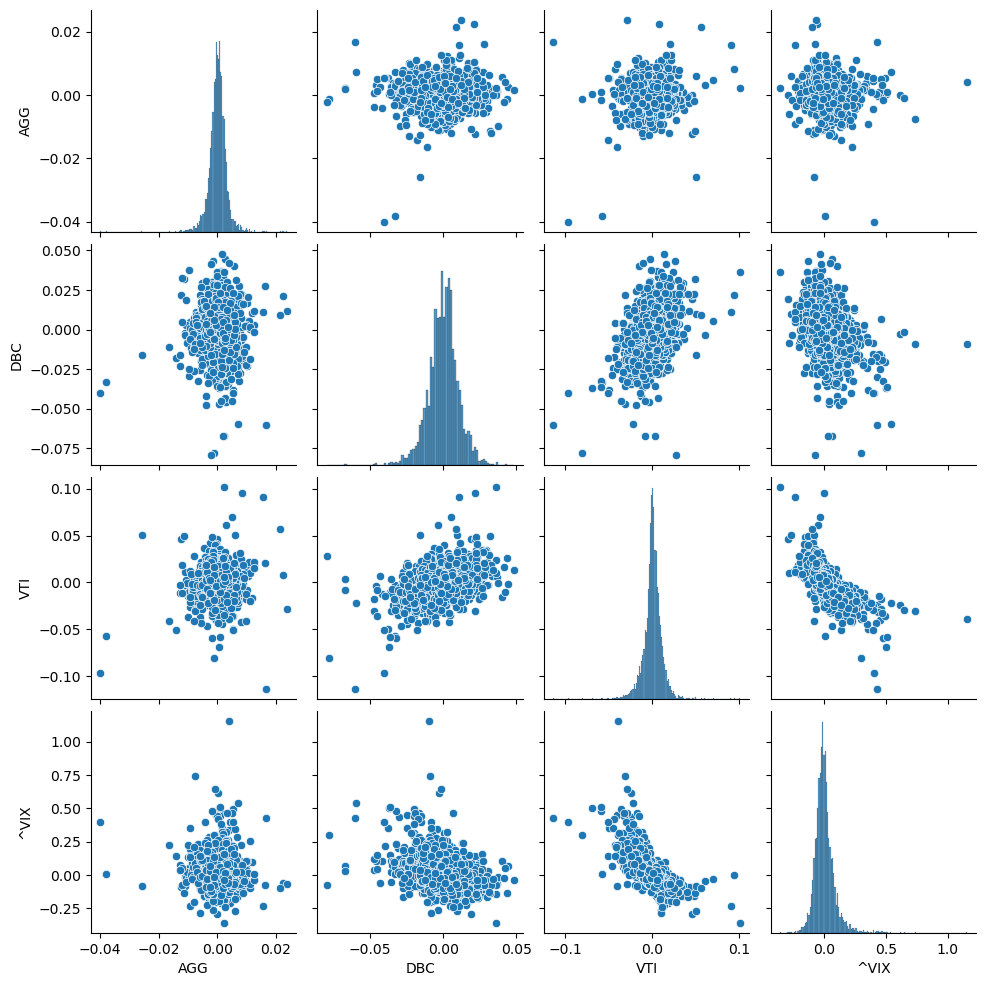

In [9]:
returns = data.pct_change()[1:].fillna(0)
sns.pairplot(data.pct_change());

## Are the returns normally distributed?

In [10]:
from scipy.stats import kurtosis,skew,jarque_bera

kurtosis(returns),skew(returns)

(array([20.56001542,  3.8246603 , 11.98347913, 17.14140928]),
 array([-1.0554332 , -0.57223889, -0.35528278,  2.25815344]))

In [11]:
for i in returns.columns:
    _,p_value = jarque_bera(returns[i])
    print("Normality test of " + i + " return: " + str(p_value>0.05))

Normality test of AGG return: False
Normality test of DBC return: False
Normality test of VTI return: False
Normality test of ^VIX return: False


Returns are not normally distributed. Normality of returns is the main assumption of Sharpe Ratio.

In [12]:
# Standardization and data preparation functions
def standardize_train(data):
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    data = pd.DataFrame(data, columns=scaler.get_feature_names_out())
    return scaler, data

def standardize(data, scaler):
    data = scaler.transform(data)
    data = pd.DataFrame(data, columns=scaler.get_feature_names_out())
    return data

def add_pct_change(data):
    percentage_returns = data.pct_change()
    percentage_returns.fillna(0, inplace=True)
    percentage_returns.columns = ['%returnsAGG', '%returnsDBC', '%returnsVTI', '%returnsVIX']
    percentage_returns.index = data.index
    return pd.concat([data, percentage_returns], axis=1)

In [13]:
# Split data
train = data.loc[:'2020-05-01']
val = data.loc['2020-05-02':'2022-02-02']
test = data.loc['2022-02-03':]

train.shape, val.shape, test.shape

((2519, 4), (443, 4), (811, 4))

In [14]:
train.isnull().values.any()

False

In [15]:
train.head()

Ticker,AGG,DBC,VTI,^VIX
Date,,,,
2010-04-30,70.167656,21.357914,46.501293,22.049999
2010-05-03,70.034775,21.462780,47.127529,20.190001
2010-05-04,70.316673,20.886009,45.981976,23.840000
2010-05-05,70.262932,20.414108,45.607784,24.910000
2010-05-06,70.363625,20.012121,44.072750,32.799999


In [16]:
# Prepare data with returns
train_with_returns = add_pct_change(train)
val_with_returns = add_pct_change(val)
test_with_returns = add_pct_change(test)

# Standardize data
scaler, train_with_returns = standardize_train(train_with_returns)
val_with_returns = standardize(val_with_returns, scaler)
test_with_returns = standardize(test_with_returns, scaler)

In [17]:
train_with_returns.head()

,AGG,DBC,VTI,^VIX,%returnsAGG,%returnsDBC,%returnsVTI,%returnsVIX
0,-2.051498,0.659932,-1.388059,0.643811,-0.060224,0.025703,-0.042792,-0.041128
1,-2.070574,0.680846,-1.367653,0.389393,-0.797929,0.507345,1.170336,-1.040757
2,-2.030105,0.565817,-1.404982,0.888654,1.507738,-2.610419,-2.232441,2.101224
3,-2.037820,0.471703,-1.417175,1.035013,-0.357944,-2.190674,-0.775852,0.490749
4,-2.023365,0.391531,-1.467196,2.114237,0.498026,-1.905954,-3.074678,3.712382


In [18]:
# Build sequences for LSTM
window = 50

def build_sequences(data, predict_data, window):
    X, y = [], []
    for i in range(data.shape[0] - window):
        X.append(data[i:(i+window)])
        y.append(predict_data.iloc[i+window])
    return np.array(X), np.array(y)

X_train, y_train = build_sequences(train_with_returns, train, window)
X_val, y_val = build_sequences(val_with_returns, val, window)
X_test, y_test = build_sequences(test_with_returns, test, window)

In [19]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((2469, 50, 8), (2469, 4), (393, 50, 8), (393, 4), (761, 50, 8), (761, 4))

In [20]:
# Create datasets
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

In [21]:
# LSTM Model
input_shape, output_shape = list(X_train.shape[1:]), y_train.shape[1:][0]

input_layer = tfkl.Input(shape=input_shape, name='Input', dtype='float32')
lstm = tfkl.LSTM(units=64)(input_layer)
dropout = tfkl.Dropout(0.2)(lstm)
output_layer = tfkl.Dense(output_shape, activation='softmax')(dropout)

model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
model.summary()

optimizer = tfk.optimizers.Adam(learning_rate=1e-4)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 50, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,948 (74.02 KB)

 Trainable params: 18,948 (74.02 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
class NegativeSharpeRatioLoss(tfk.losses.Loss):
    def __init__(self, name="Sharpe Ratio Loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        portfolio_values = tf.reduce_sum(tf.multiply(y_true, y_pred), axis=1)
        portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]
        sharpe = tfk.backend.mean(portfolio_returns) / tfk.backend.std(portfolio_returns)
        return -sharpe

def compute_sharpe_ratio(weights, data):
    if type(data) != pd.DataFrame:
        data = pd.DataFrame(data)
    portfolio_values = weights * data
    portfolio_values = [sum(portfolio_values.iloc[i]) for i in range(portfolio_values.shape[0])]
    portfolio_returns = (np.subtract(portfolio_values[1:], portfolio_values[:-1]))/portfolio_values[:-1]
    return np.mean(portfolio_returns)/np.std(portfolio_returns)

In [23]:
# Portfolio optimization functions
def equal_weight_portfolio(n_assets):
    return np.ones(n_assets) / n_assets

def markowitz_portfolio(returns):
    mu = expected_returns.mean_historical_return(returns)
    S = risk_models.sample_cov(returns)
    ef = EfficientFrontier(mu, S)
    #ef.add_objective(objective_functions.L2_reg)  # Add regularization
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    return np.array([cleaned_weights[k] for k in cleaned_weights])

def lstm_portfolio(predictions):
    # Average weights from LSTM predictions
    return np.mean(predictions, axis=0)

In [24]:
# Train the LSTM model
epochs = 20
training_loss = []
val_metric = []

def training(model, train_dataset, val_dataset, custom_loss):
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch))
        
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                logits = model(x_batch_train, training=True)
                loss_value = custom_loss(y_batch_train, logits)
            
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
        
        print("Training loss at epoch %d: %.4f" % (epoch, float(loss_value)))
        training_loss.append(loss_value)

        weights, values = None, None
        for x_batch_val, y_batch_val in val_dataset:
            val_logits = model(x_batch_val, training=False)
            if weights is None:
                weights = val_logits
                values = y_batch_val
            else:
                weights = np.concatenate([np.array(weights, dtype=float), np.array(val_logits, dtype=float)])
                values = np.concatenate([np.array(values, dtype=float), np.array(y_batch_val, dtype=float)])
        sr = compute_sharpe_ratio(weights, values)

        print("Validation metric at epoch %d: %.4f" % (epoch, float(sr)))
        val_metric.append(sr)

training(model, train_dataset, val_dataset, NegativeSharpeRatioLoss())


Start of epoch 0
Training loss at epoch 0: -0.0616
Validation metric at epoch 0: 0.0293

Start of epoch 1
Training loss at epoch 1: -0.0834
Validation metric at epoch 1: 0.0291

Start of epoch 2
Training loss at epoch 2: -0.0580
Validation metric at epoch 2: 0.0289

Start of epoch 3
Training loss at epoch 3: -0.0543
Validation metric at epoch 3: 0.0289

Start of epoch 4
Training loss at epoch 4: -0.0609
Validation metric at epoch 4: 0.0283

Start of epoch 5
Training loss at epoch 5: -0.0660
Validation metric at epoch 5: 0.0277

Start of epoch 6
Training loss at epoch 6: -0.0603
Validation metric at epoch 6: 0.0270

Start of epoch 7
Training loss at epoch 7: -0.0819
Validation metric at epoch 7: 0.0265

Start of epoch 8
Training loss at epoch 8: -0.0853
Validation metric at epoch 8: 0.0260

Start of epoch 9
Training loss at epoch 9: -0.0855
Validation metric at epoch 9: 0.0250

Start of epoch 10
Training loss at epoch 10: -0.0900
Validation metric at epoch 10: 0.0244

Start of epoch 11

Text(0, 0.5, 'Sharpe ratio')

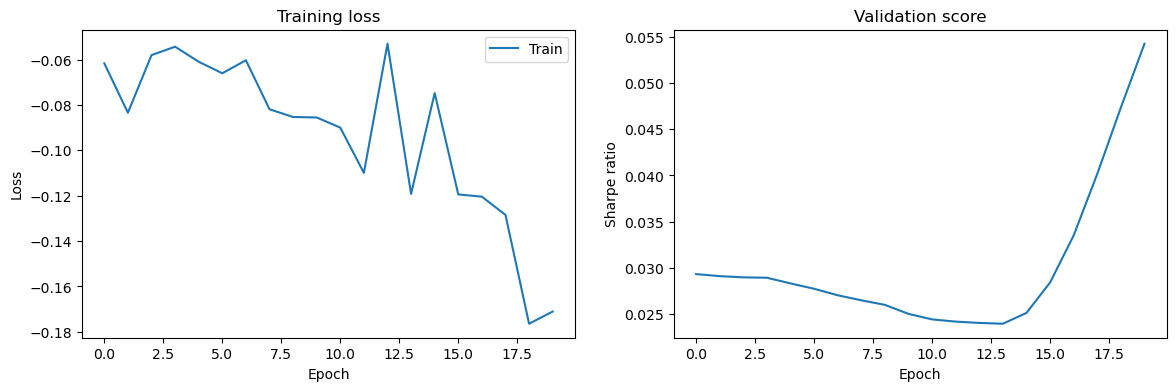

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
ax1.plot(training_loss)
ax1.legend(['Train'])
ax1.set_title('Training loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(val_metric)
ax2.set_title('Validation score')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Sharpe ratio')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 


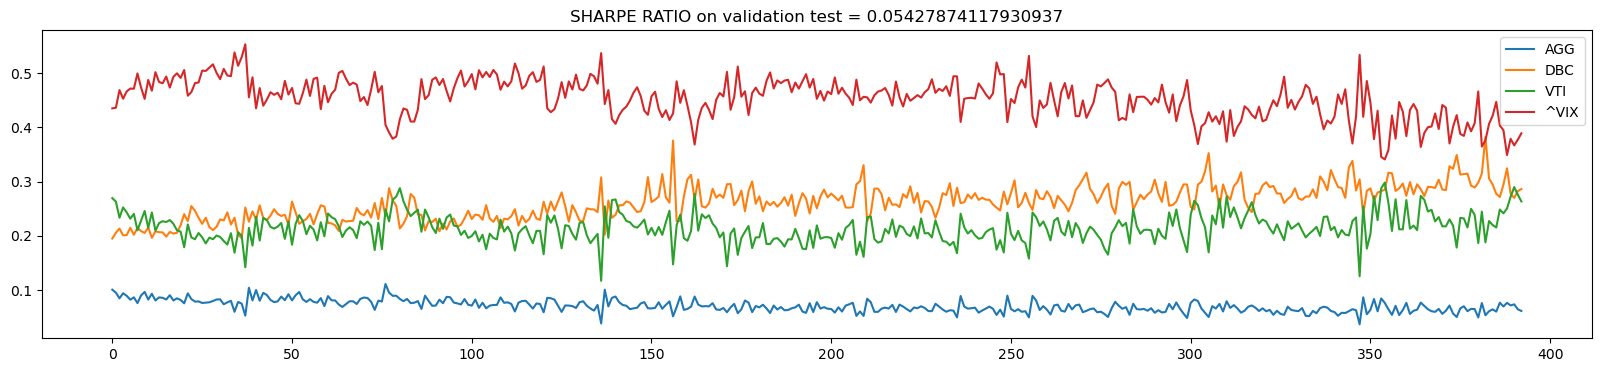

In [26]:
predictions = model.predict(X_val)
df = np.array(predictions).transpose()
plt.figure(figsize=[20,4])
for i in range(df.shape[0]):
    plt.plot(df[i],label=etfs[i])
plt.title('SHARPE RATIO on validation test = ' + str(compute_sharpe_ratio(predictions,val[50:])))
plt.legend()

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


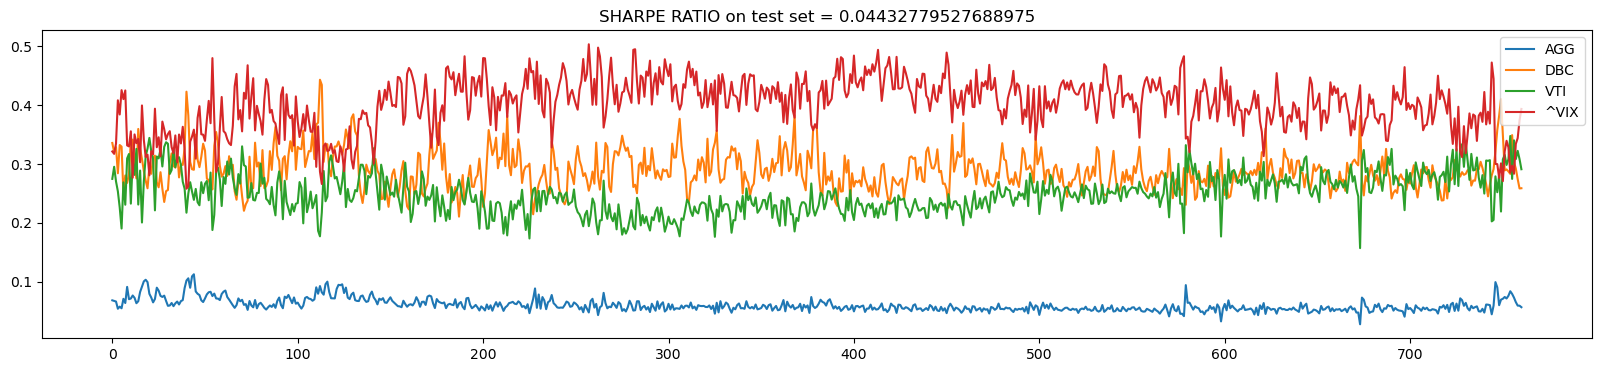

In [27]:
predictions = model.predict(X_test)
df = np.array(predictions).transpose()
plt.figure(figsize=[20,4])
for i in range(df.shape[0]):
    plt.plot(df[i],label=etfs[i])
plt.title('SHARPE RATIO on test set = ' + str(compute_sharpe_ratio(predictions,test[50:])))
plt.legend()

In [28]:
# Get predictions
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [29]:
# Calculate weights for each strategy
n_assets = len(etfs)
equal_weights = equal_weight_portfolio(n_assets)

markowitz_weights = markowitz_portfolio(train)

# For LSTM, we'll use the average weights from predictions
lstm_weights = lstm_portfolio(test_predictions)

In [53]:
# Backtest the strategies
def backtest(weights, returns):
    portfolio_values = np.sum(weights * returns, axis=1)
    portfolio_returns = portfolio_values.pct_change().dropna()
    print("Expected Returns:", -1*portfolio_returns.mean())
    print("Standard Deviation:", portfolio_returns.std())
    sharpe_ratio = -1*portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)  # Annualized
    return portfolio_values, sharpe_ratio

# Use test set returns for backtesting
test_returns = test.pct_change().dropna()

# Calculate portfolio values and Sharpe ratios
equal_portfolio, equal_sharpe = backtest(equal_weights, test_returns)
markowitz_portfolio, markowitz_sharpe = backtest(markowitz_weights, test_returns)
lstm_portfolio, lstm_sharpe = backtest(lstm_weights, test_returns)

Expected Returns: 4.594174260811408
Standard Deviation: 125.53900344304088
Expected Returns: 1.2944254944642528
Standard Deviation: 10.954207201890917
Expected Returns: 2.7094245637948298
Standard Deviation: 33.78664934184847


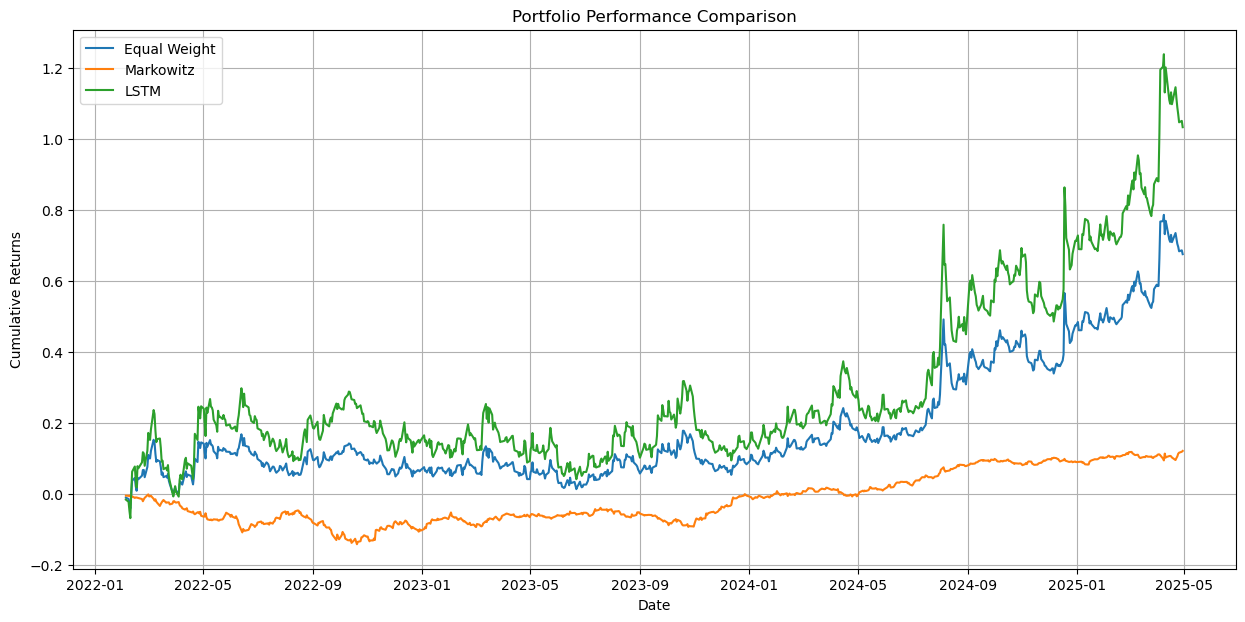

In [57]:
# Plot results
plt.figure(figsize=(15, 7))
plt.plot(test_returns.index, equal_portfolio.cumsum(), label=f'Equal Weight')
plt.plot(test_returns.index, markowitz_portfolio.cumsum(), label=f'Markowitz')
plt.plot(test_returns.index, lstm_portfolio.cumsum(), label=f'LSTM')
plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Print weights comparison
print("\nPortfolio Weights Comparison:")
print(f"Equal Weights: {equal_weights}")
print(f"Markowitz Weights: {markowitz_weights}")
print(f"LSTM Weights: {lstm_weights}")


Portfolio Weights Comparison:
Equal Weights: [0.25 0.25 0.25 0.25]
Markowitz Weights: [0.72293 0.      0.25423 0.02284]
LSTM Weights: [0.05987297 0.2890516  0.24950396 0.40157175]


In [50]:
# Print Sharpe ratios comparison
print("\nSharpe Ratios Comparison:")
print(f"Equal Weight: {-1*equal_sharpe:.4f}")
print(f"Markowitz: {-1*markowitz_sharpe:.4f}")
print(f"LSTM: {-1*lstm_sharpe:.4f}")


Sharpe Ratios Comparison:
Equal Weight: 0.5809
Markowitz: 1.8758
LSTM: 1.2730


In [34]:
window = 50

def build_sequences(data,returns,window):
    X = []
    y = []
    for i in range(returns.shape[0] - window):
        x_i = returns[i:(i+window)]
        X.append(x_i)
        y_i = returns.iloc[i+window]
        y.append(y_i)
    return np.array(X),np.array(y)

#X_train,y_train = build_sequences(None,train,window)
#X_val,y_val = build_sequences(None,val,window)

In [35]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]
batch_size = 64
epochs = 20

In [36]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.LSTM(units=64,return_sequences=True)(input_layer)
    dense = tfkl.Dense(32)(lstm)
    flattening = tfkl.Flatten()(dense)
    output_layer = tfkl.Dense(output_shape, activation='relu')(flattening)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=[tfk.losses.MeanSquaredError(),], optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [37]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 50, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         6,404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,172 (106.14 KB)

 Trainable params: 27,172 (106.14 KB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [38]:
history = model.fit(X_train,y_train,epochs=500,validation_split=.2,
                    callbacks = [
                        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
                        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-7)
                    ])

Epoch 1/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2814.7446 - mae: 41.7559 - val_loss: 368.3871 - val_mae: 13.8138 - learning_rate: 0.0010
Epoch 2/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 280.2867 - mae: 11.6676 - val_loss: 446.9034 - val_mae: 15.0020 - learning_rate: 0.0010
Epoch 3/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 123.4387 - mae: 7.9843 - val_loss: 219.3799 - val_mae: 11.2726 - learning_rate: 0.0010
Epoch 4/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 110.7959 - mae: 7.0431 - val_loss: 169.1827 - val_mae: 9.9590 - learning_rate: 0.0010
Epoch 5/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 107.4284 - mae: 6.7982 - val_loss: 151.1187 - val_mae: 9.4330 - learning_rate: 0.0010
Epoch 6/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 105.2334 - mae: 6.5901 - val_loss: 131.5826 - val_mae: 8.7143 - learning_rate: 0.0010
Epoch 7/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 103.5867 - mae: 6.4185 - val_loss: 122.7565 - val_mae: 8.34

In [39]:
model.save_weights('model_w_ret.weights.h5')

In [40]:
model.load_weights('model_w_ret.weights.h5')

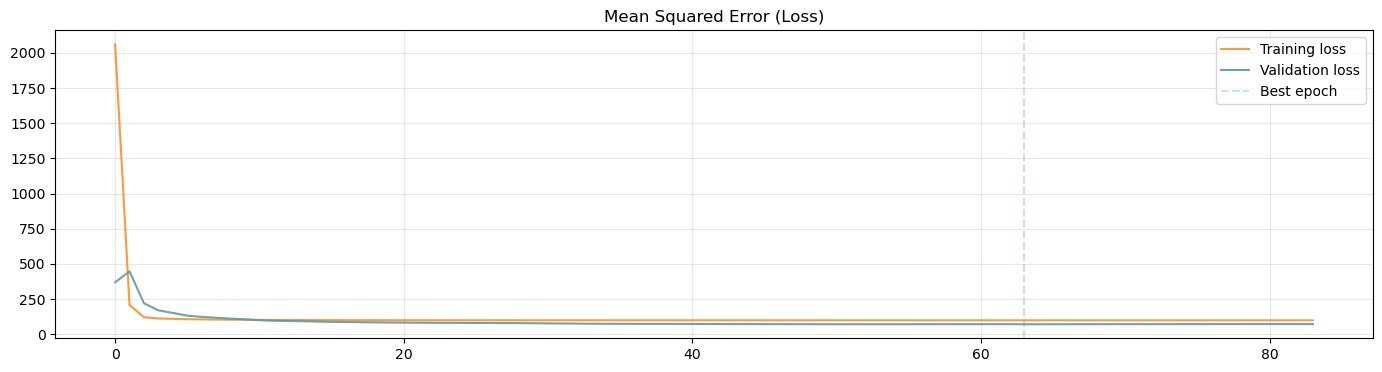

In [41]:
best_epoch = np.argmin(history.history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history.history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [42]:
# Predict the test set
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
(761, 4)


(<tf.Tensor: shape=(), dtype=float32, numpy=8433.658203125>,
 <tf.Tensor: shape=(), dtype=float32, numpy=65.6974868774414>)

<Figure size 1700x400 with 0 Axes>

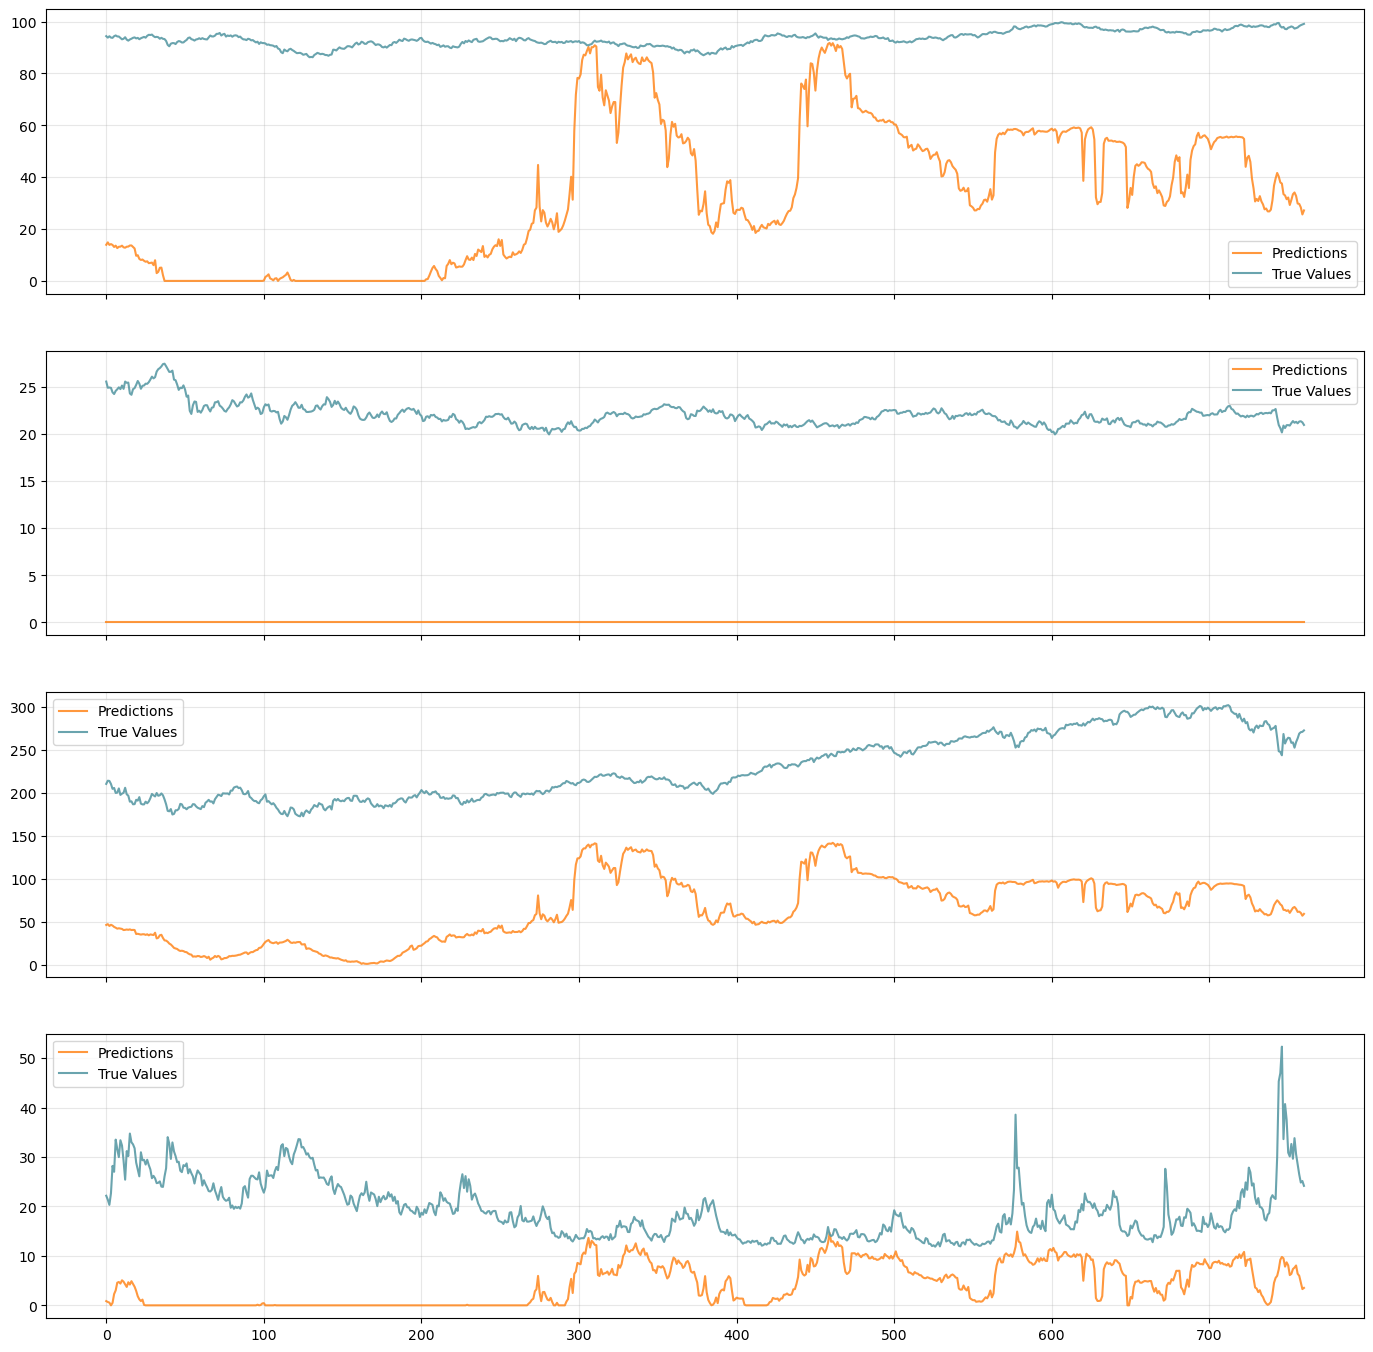

In [43]:
plt.figure(figsize=(17,4))
figs, axs = plt.subplots(4, 1, sharex=True, figsize=(17,17))
for i in range(4):
    axs[i].plot(predictions[:,i], label='Predictions', alpha=.8, color='#ff7f0e')
    axs[i].plot(y_test[:,i], label='True Values', alpha=.9, color='#5a9aa5')
    axs[i].legend()
    axs[i].grid(alpha=.3)
plt.show()

In [44]:
import scipy.optimize as opt
def MaximizeSharpeRatio(data):
    # define negative sharpe ratio
    def  f(x, mean, cov):
        funcDen = np.sqrt(np.matmul(np.matmul(x, cov), x.T) )
        funcNumer = np.matmul(np.array(mean),x.T)
        func = -(funcNumer / funcDen)
        return func

    size = data.shape[1]
    mean = np.mean(data,axis=0)
    covar = np.cov(data,rowvar=False)
    #define bounds and other parameters
    xinit=np.repeat(1/size, size)
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},)
    bnds = opt.Bounds(([0 for x in xinit]), [1 for x in xinit], keep_feasible=True)

    solver = opt.minimize(f, x0 = xinit, args = (mean, covar), method = 'SLSQP',
                             bounds = bnds,constraints=cons, tol = 10**-3,options={'disp':True})
    return solver

In [45]:
weights=[]
sharpe_values = []
for i in range(X_test.shape[0]):
    np.append(X_test[i][:,:4], model.predict((X_test[i])[np.newaxis,:]) ,axis=0)
    returns =(X_test[i][:,:4][1:] - X_test[i][:,:4][:-1]) / X_test[i][:,:4][:-1]
    solver = MaximizeSharpeRatio(returns)
    if solver.success:
        weights.append(solver.x)
        sharpe_values.append(solver.fun)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.3795642882312812
            Iterations: 12
            Function evaluations: 67
            Gradient evaluations: 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.3668655508544231
            Iterations: 11
            Function evaluations: 60
            Gradient evaluations: 11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.36602207712383844
            Iterations: 10
            Function evaluations: 56
            Gradient evaluations: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.36861201265655014
            Iterations: 13
            Function evaluations: 72
            Gradient evaluations: 13
1/

In [46]:
np.mean(sharpe_values)*(-1)

0.11817836133087574

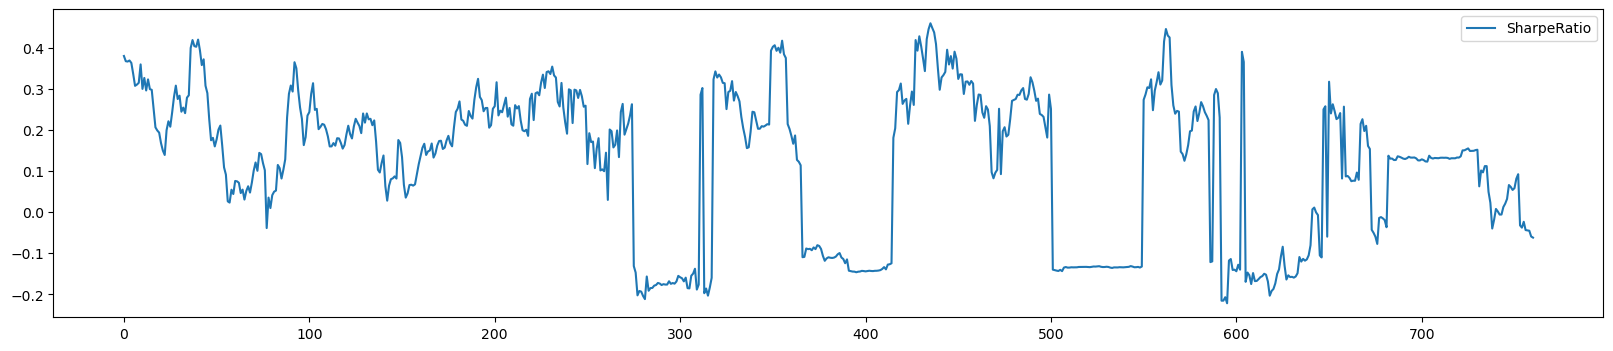

In [47]:
plt.figure(figsize=[20,4])
plt.plot(np.multiply(sharpe_values,(-1)),label='SharpeRatio')
plt.legend()

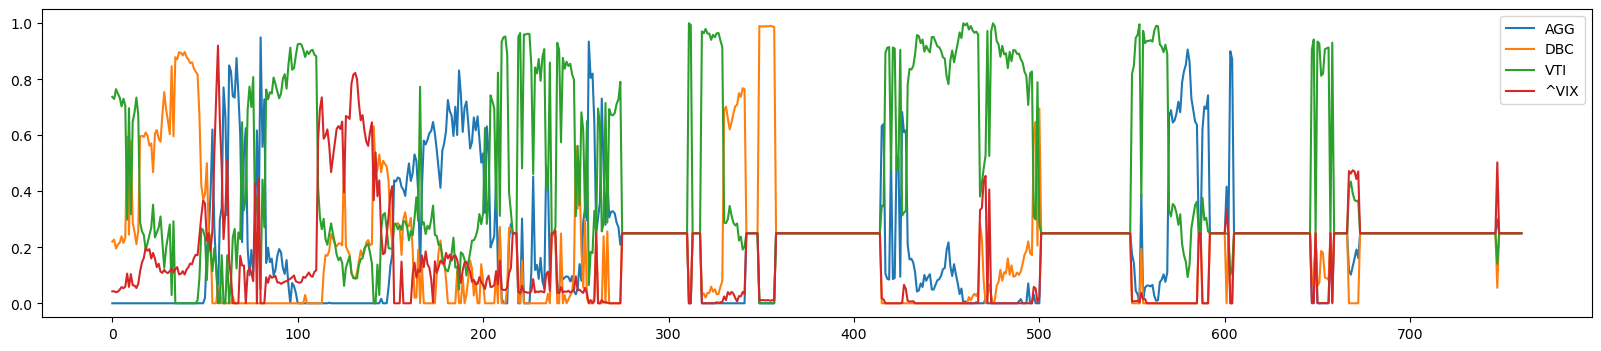

In [48]:
df = np.array(weights).transpose()
plt.figure(figsize=[20,4])
for i in range(df.shape[0]):
    plt.plot(df[i],label=etfs[i])
plt.legend()